In [41]:
import os
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

plt.ioff()
plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

tfkl = tf.keras.layers
tfpl = tfp.layers
tf.keras.backend.set_floatx("float64")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [42]:
def load_mdn(DT, N_C, user):
    """
    Loads MDN model.
    """

    model = tf.keras.Sequential(
        [tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(512, activation='tanh'),
         tfkl.Dense(512, activation='tanh'),
         tfkl.Dense(N_C * 15, activation=None),
         tfpl.MixtureSameFamily(N_C, tfpl.MultivariateNormalTriL(4))])

    model.load_weights(
        f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/trained/weights.index").expect_partial()
    return model

In [66]:
def load_scalers(DT, N_C, user):
    """
    Loads scaler objects relating to MDN models.
    """

    with open(f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/Xscaler.pkl", "rb") as file:
        Xscaler = pickle.load(file)

    with open(f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/Yscaler.pkl", "rb") as file:
        Yscaler = pickle.load(file)
    return Xscaler, Yscaler

def given(X_1, X_0, X_scaler, Y_scaler, model):
    """
    Evaluates transition density for fixed X_0.
    """
    return Y_scaler.invert_standardisation_prob(
        np.exp(
            model.log_prob(
                X_scaler.standardise(X_1)))
        )

In [83]:
def plot_transition_densities(A0, B0, A1, DT, N_C, user, disc_n=20):
    # Load our trained model.
    model = load_mdn(DT, N_C, user)

    # Load the model scalers.
    X_scaler, Y_scaler = load_scalers(DT, N_C, user)

    # Combine the initial positions to get a vector our model can understand.
    initial_position = np.hstack([A0, B0]).reshape(4, 1)

    model_at_init = model(X_scaler.standardise(initial_position))

    x = np.linspace(0, 1, disc_n)
    y = np.linspace(0, 1, disc_n)
    xx, yy = np.meshgrid(x, y, copy=True)

    B1_positions = np.vstack([xx.ravel(), yy.ravel()])
    # print(f"{B1_positions.shape = }")

    A1_positions = np.repeat(A1, disc_n**2, axis=1)
    # print(f"{A1_positions.shape = }")

    updated_positions = np.vstack([A1_positions, B1_positions])
    # print(f"{updated_positions.shape = }")

    probs = np.zeros_like(updated_positions)

    for i in range(updated_positions.shape[1]):
        p = updated_positions[:, i]
        probs[:, i] = given(p, initial_position, X_scaler, Y_scaler, model_at_init)

    x0_1_probs = probs[0, :].reshape((disc_n, disc_n))
    # x0_2_probs = probs[1, :].reshape((disc_n, disc_n))
    x1_1_probs = probs[2, :].reshape((disc_n, disc_n))
    # x1_2_probs = probs[3, :].reshape((disc_n, disc_n)) 

    print(probs)

    _, axs = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 6))
    
    # cmap=cm.RdYlBu

    # axs = axs.flatten()
    axs.plot_surface(xx, yy, x0_1_probs, cmap="Reds", linewidth=0.5, edgecolors='k', label="x1")
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    # axs[1].plot_surface(xx, yy, x0_2_probs, cmap="blues", linewidth=0.5, edgecolors='k')
    # axs[1].set_xlabel("x")
    # axs[1].set_ylabel("y")
    axs.plot_surface(xx, yy, x1_1_probs, cmap="Blues", linewidth=0.5, edgecolors='k', label="x0")
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    # axs[3].plot_surface(xx, yy, x1_2_probs, cmap=cm.RdYlBu, linewidth=0.5, edgecolors='k')
    # axs[3].set_xlabel("x")
    # axs[3].set_ylabel("y")

    axs.legend()

    plt.show()
    return

[[0.00698863 0.01315465 0.0231533  ... 0.0238452  0.01344452 0.00708459]
 [0.00698863 0.01315465 0.0231533  ... 0.0238452  0.01344452 0.00708459]
 [0.00878757 0.01641875 0.02860011 ... 0.02943812 0.01711029 0.00930935]
 [0.00878757 0.01641875 0.02860011 ... 0.02943812 0.01711029 0.00930935]]


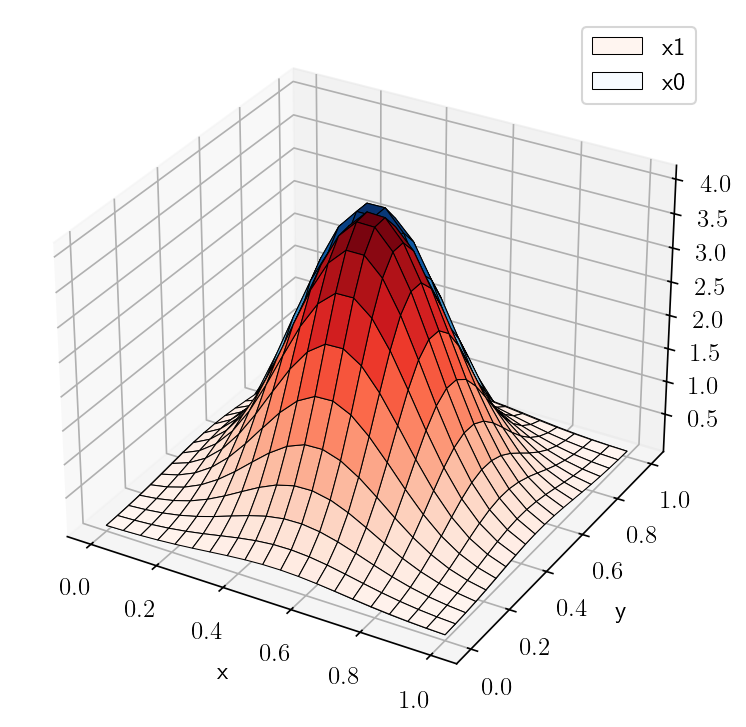

[[0.07293085 0.13699625 0.2397251  ... 0.21977399 0.12469497 0.06600095]
 [0.07293085 0.13699625 0.2397251  ... 0.21977399 0.12469497 0.06600095]
 [0.06189012 0.11932563 0.21448629 ... 0.25968516 0.14823368 0.0789218 ]
 [0.06189012 0.11932563 0.21448629 ... 0.25968516 0.14823368 0.0789218 ]]


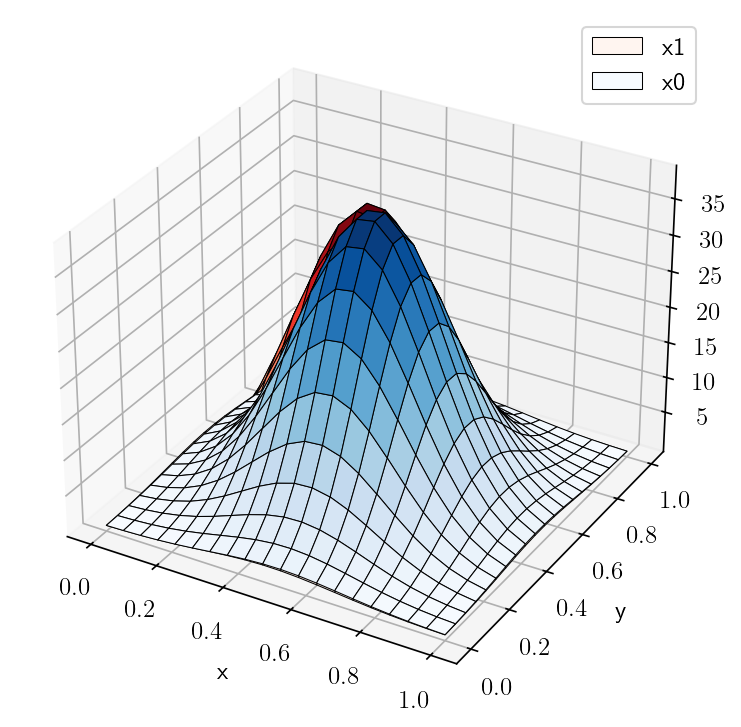

In [85]:
# Model parameters.
N_C = 32
DT = 4
user = "masha"

 # Define the initial position of the first particle
A0 = np.array([0.4, 0.4])
# and the second particle.
B0 = np.array([0.6, 0.6])

# Fix the position of the second point, A1.
A1 = np.array([0.8, 0.8]).reshape(2, 1)

plot_transition_densities(A0, B0, A1, DT, N_C, user)

A1 = np.array([0.5, 0.5]).reshape(2, 1)
plot_transition_densities(A0, B0, A1, DT, N_C, user)

In [40]:
probs = np.zeros_like(updated_positions)

for i in range(updated_positions.shape[1]):
    p = updated_positions[:, i]
    # print(p)
    prob = given(p, initial_position, X_scaler, Y_scaler, model_at_init)
    # print(prob, "\n")

    probs[:, i] = prob


# print(f"{probs.shape = }")

# print(probs)

x0_probs = probs[0, :].reshape((disc_n, disc_n))
x1_probs = probs[2, :].reshape((disc_n, disc_n))

# print(x0_probs)


# plt.figure(figsize=(8, 6))
# plt.contourf(xx, yy, x0_probs, cmap='viridis', label="X0")
# plt.colorbar(label='Probability Density')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('2D Gaussian Distribution')
# plt.grid(True)
# plt.show()